# Fraud Detection


# Part 0: Library Imports and Load Data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import shap


# Load data (5% sample)
data_path = r"C:/Users/lukew/Dir.Python/creditcard.csv"
df = pd.read_csv(data_path).sample(frac=0.05, random_state=42)
df['LogAmount'] = np.log(df['Amount'] + 1)

# Part 1: EDA + Logistic Regression

# EDA: Transaction Time
The Transaction Time Distribution plot above provides critical insight into the temporal behavior of transactions within the sampled credit card dataset. On the x-axis, we have transaction time measured in seconds since the beginning of the data collection period, and the y-axis represents the frequency (or count) of transactions occurring within each time bin.

One of the first observations I make is the bimodal nature of this distribution. This indicates that transaction activity is not uniformly distributed across time. Instead, there appear to be two distinct peaks — periods of high activity — separated by troughs of reduced transaction volume. This pattern is often reflective of diurnal activity, possibly capturing daytime transactions from users in different time zones or usage clusters like weekday working hours and evening leisure activity.

From a modeling standpoint, this kind of non-uniform distribution over time could suggest that time may be an indirect proxy for behavioral patterns. For instance, fraudsters may exploit lower-activity windows to bypass detection systems. However, the time variable in its raw form (seconds since a reference point) is not inherently meaningful — it lacks cyclical interpretation (e.g., hour of day, weekday vs weekend) unless it’s engineered into a more interpretable feature (like time_of_day, is_weekend, or converted to sine/cosine encodings for periodicity).

Thus, while this variable’s correlation with fraud may not be strong in the raw format, its underlying structure tells us there’s a temporal rhythm to user behavior, and future iterations of the model might benefit from feature engineering to extract periodic patterns or even temporal anomaly detection strategies.

In summary, this plot isn’t just descriptive — it is a launching point for:

    -Temporal feature engineering,

    -Fraud pattern hypothesis generation,

    -And modeling refinements that capture cyclic user behavior.

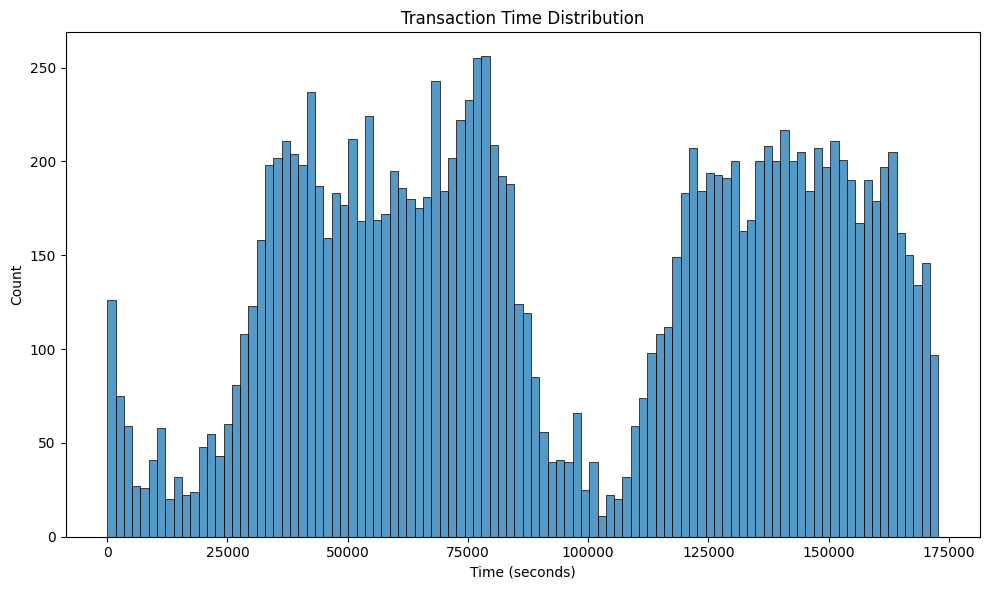

In [24]:
# EDA: Transaction Time
plt.figure(figsize=(10,6))
sns.histplot(df['Time'], bins=100)
plt.title("Transaction Time Distribution")
plt.xlabel("Time (seconds)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Temporal Fraud Risk Analysis: Hourly Patterns and Peak Activity Windows

Both plots collectively uncover meaningful temporal patterns in fraudulent behavior, shedding light on when fraud is more likely to occur and how it aligns with general transaction activity.

From the hourly fraud rate plot, we observe considerable variation in fraud frequency throughout the day, with certain hours — particularly around 11AM and 11PM — exhibiting noticeable spikes. This suggests that fraud is not evenly distributed across time but rather clustered during specific operational windows, potentially when system monitoring thresholds or human alertness might be suboptimal. These fluctuations emphasize the importance of treating "time of day" not just as a raw numerical variable, but as a categorical or cyclic input that captures behavioral rhythms. It also motivates the creation of engineered features like hour_sin/cos or time binning to preserve cyclic relationships in fraud detection models.

The peak vs off-peak comparison reinforces and simplifies this insight: even though we might expect fraudsters to operate under the cover of night, the data reveals a higher fraud rate during peak daytime hours (6AM–11PM). This counterintuitive finding likely reflects fraudsters exploiting high transaction volumes to mask illicit activity, knowing that their actions are less likely to trigger alarms when buried among thousands of legitimate daytime purchases. Together, these plots advocate for time-aware modeling strategies and the inclusion of interaction terms between time and transaction features to better detect anomalous patterns that would otherwise remain hidden in noise.

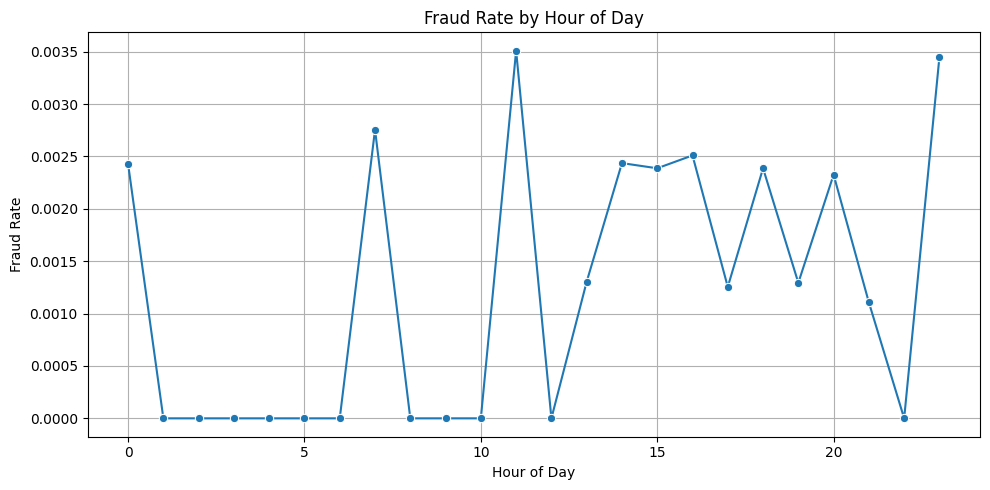

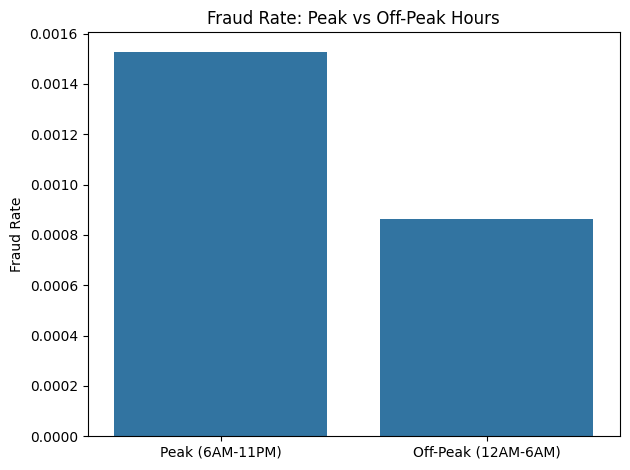

In [25]:
# Add time features
df['HourOfDay'] = (df['Time'] % 86400) // 3600

# Cyclical encoding for periodicity (sin and cos transform)
df['TimeSin'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['TimeCos'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

# Flag off-peak (0 to 6 hours)
df['IsOffPeak'] = df['HourOfDay'].apply(lambda x: 1 if x < 6 else 0)

hourly_fraud_rate = df.groupby('HourOfDay')['Class'].mean()
plt.figure(figsize=(10,5))
sns.lineplot(x=hourly_fraud_rate.index, y=hourly_fraud_rate.values, marker='o')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

offpeak_rate = df.groupby('IsOffPeak')['Class'].mean()
sns.barplot(x=['Peak (6AM-11PM)', 'Off-Peak (12AM-6AM)'], y=offpeak_rate.values)
plt.title('Fraud Rate: Peak vs Off-Peak Hours')
plt.ylabel('Fraud Rate')
plt.tight_layout()
plt.show()



# EDA: Class Distribution
## Severe Class Imbalance and the Pitfall of Accuracy in Fraud Detection
The pie chart shown provides a stark illustration of class imbalance—a common and critical challenge in fraud detection tasks. Here, the dataset consists of approximately 99.85% legitimate (non-fraudulent) transactions and a mere 0.15% fraudulent transactions. This imbalance implies that out of 10,000 transactions, only about 15 are fraudulent. While such distributions reflect real-world phenomena—where fraud is rare but costly—they introduce serious modeling challenges.

One of the most deceptive consequences of class imbalance is its distortion of overall model accuracy. Suppose a naive model simply predicts every transaction as non-fraudulent. It would be correct 99.85% of the time, yielding near-perfect accuracy. However, such a model would fail entirely at identifying actual fraud, which is the true business objective. This illustrates why accuracy is a misleading performance metric in highly imbalanced settings. A model with 99.85% accuracy could have 0% recall for the fraud class, meaning not a single fraudulent transaction is flagged—a catastrophic failure in production environments like banking or e-commerce.

To combat this, fraud detection models must be evaluated using precision, recall, F1-score, and especially the ROC-AUC score, which assess performance with respect to the minority class. Techniques such as SMOTE (Synthetic Minority Over-sampling Technique), class weighting, and threshold tuning become essential to ensure the model does more than just "play it safe." The goal is not to be generally correct, but to be specifically correct when it matters most—on the few transactions that carry disproportionately high financial risk.

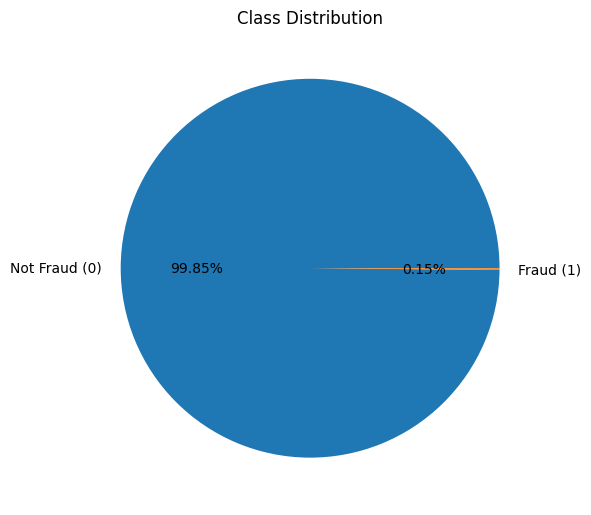

In [26]:
plt.figure(figsize=(6,6))
plt.pie(df['Class'].value_counts(), labels=['Not Fraud (0)','Fraud (1)'], autopct='%1.2f%%')
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

# EDA: LogAmount by Class
## Transaction Amounts and Their Relationship to Fraud

The histogram above shows the distribution of log-transformed transaction amounts, stratified by fraud class. The log transformation was applied to normalize the distribution and reduce the influence of extreme outliers, a standard preprocessing step when dealing with monetary values that often exhibit long-tailed behavior. Class 0 (non-fraud) transactions dominate the distribution, as expected, and span a wide range of amounts. These are visualized in blue, forming a more uniform, continuous density across values. On the other hand, fraudulent transactions (Class 1, shown in orange) exhibit a distinctly spiky and fragmented pattern with sharp peaks at specific log-scaled values, suggesting that fraudsters may favor certain fixed transaction amounts—possibly to evade automated detection systems or exploit known system thresholds.

An important observation is that fraudulent transactions are not randomly distributed across the range of transaction values. Instead, they cluster around specific small-to-mid value amounts, with some significant density around lower-value transactions. This might indicate that many fraud attempts are designed to avoid triggering alarms, staying below what might be perceived as "suspiciously high" amounts. It also raises the possibility of fraud occurring in bursts, where a few favored transaction sizes are repeatedly exploited, perhaps via scripted or automated attacks.

From a modeling perspective, this pattern suggests that the amount of the transaction is a valuable predictor for fraud, especially when transformed and combined with other temporal or behavioral features. Moreover, the presence of vertical spikes for fraudulent transactions implies that amount-based rules or thresholds alone are insufficient, and that a probabilistic, multivariate modeling approach is more suitable. This also justifies the use of ensemble methods and feature importance tools (like SHAP) to capture nonlinear interactions between amount and other predictors in the context of fraud detection.


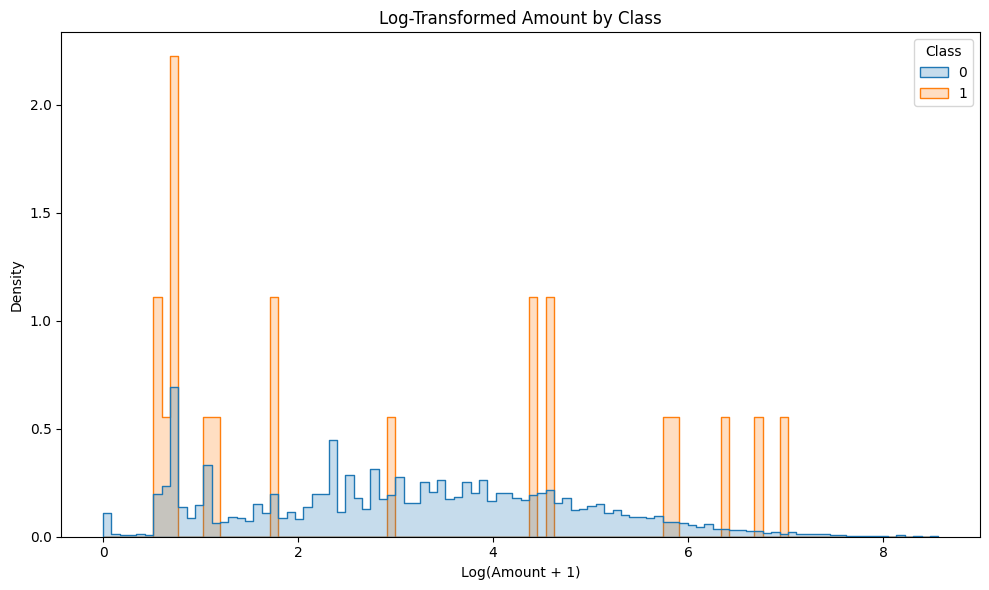

In [27]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='LogAmount', hue='Class', bins=100, element='step', stat='density', common_norm=False)
plt.title("Log-Transformed Amount by Class")
plt.xlabel("Log(Amount + 1)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# Correlation analysis
## Feature Relevance: Correlation Analysis with Fraud Labels

The heatmap above visualizes the pairwise Pearson correlations among the most predictive features and the target fraud class label. This matrix serves as an essential tool for understanding linear relationships both between predictors and between predictors and the outcome variable (Class). Notably, all features shown exhibit negative correlations with the fraud class label. For example, V17 shows the strongest (albeit modest) linear relationship with Class at approximately -0.26, followed by V14 at -0.20. This indicates that higher values of these features tend to be associated with non-fraudulent transactions, whereas lower values of these variables may be more indicative of fraud.

However, while these correlation values are useful for feature selection and preliminary screening, it's important to contextualize them. The magnitudes are relatively low, which reflects the complex and non-linear nature of fraud. This highlights the limitation of relying on linear models or simple thresholding rules alone. Moreover, many features (e.g., V7, V10, V1) show near-zero correlations with Class but may still contribute meaningfully in a multivariate context, especially in models capable of capturing interactions and non-linear boundaries such as random forests or gradient boosting machines.

This analysis underlines the importance of using correlation as a filtering tool, not a final arbiter of predictive utility. It can help eliminate obviously uninformative features but must be supplemented with domain knowledge and model-based evaluations (e.g., SHAP, permutation importance) to fully understand the value of a feature. In fraud detection especially, weak individual signals often combine into powerful ensemble predictors, reinforcing the need for robust multivariate modeling.


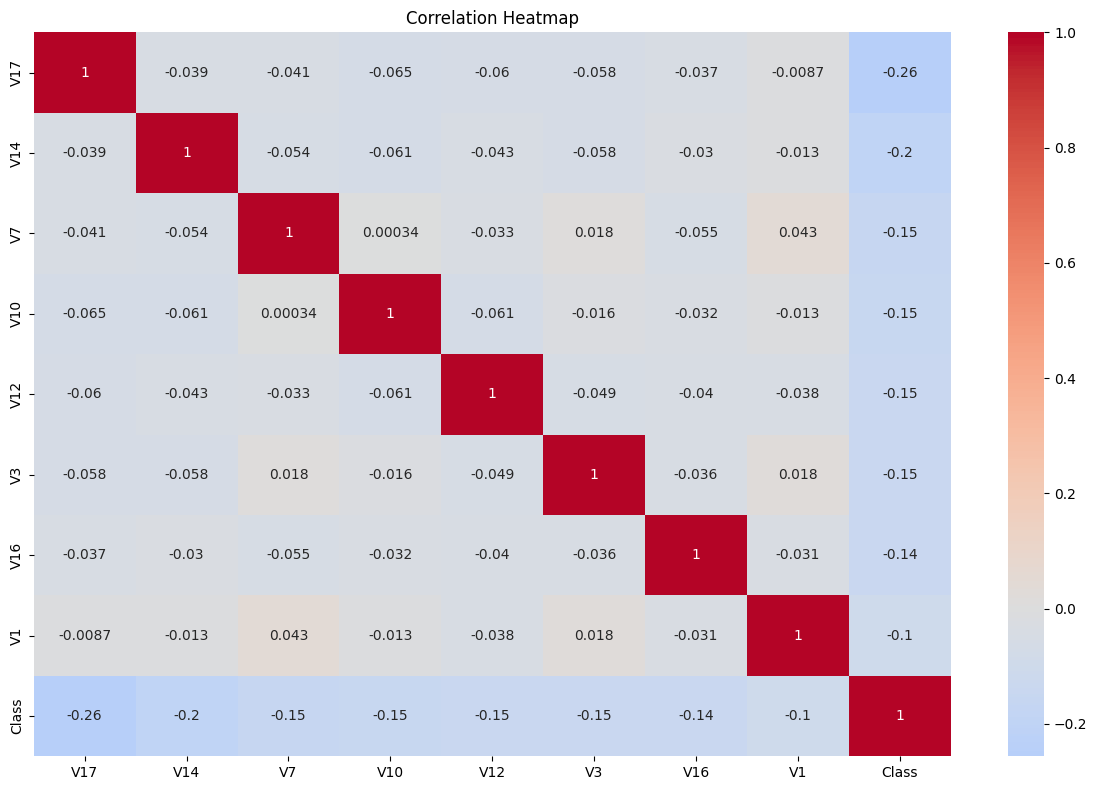

In [28]:
target_corr = df.corr()['Class'].drop('Class').sort_values(key=abs, ascending=False)
strong_feats = target_corr[abs(target_corr) > 0.1].index.tolist()

plt.figure(figsize=(12,8))
sns.heatmap(df[strong_feats + ['Class']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Logistic Regression Setup

In [29]:
# Logistic Regression Setup
X = df[strong_feats]
y = df['Class']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

logmod = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logmod.fit(X_tr_s, y_tr)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Predictions and Evaluation
The logistic regression model demonstrates a high ROC-AUC score of 0.945, indicating strong overall capability in ranking fraudulent and non-fraudulent transactions. This metric suggests that the model is well-calibrated in terms of probability prediction and is able to distinguish between the two classes effectively in a probabilistic sense. However, when examining the classification performance in more detail—especially through the classification report and confusion matrix—some critical limitations emerge. Most notably, the class of interest (fraudulent transactions) is extremely rare, representing just 0.15% of the data. Out of 2,848 test observations, only 4 are actual fraud cases, which makes reliable fraud prediction a substantial challenge.

While the model achieved 75% recall on the fraud class—meaning it correctly identified 3 out of 4 fraudulent cases—it also made 92 false positive errors, resulting in a precision of just 3%. This tradeoff leads to a very low F1-score of 0.06, highlighting the cost of incorrect fraud alarms. Such a model, if deployed without further tuning, would raise too many false alerts and likely overwhelm fraud investigators. Importantly, the overall accuracy of 97% is misleading in this context, as it reflects the model’s ability to correctly classify the majority class (non-fraud), but says little about its value in identifying the minority class where the real business impact lies. This underscores the importance of using evaluation metrics like precision, recall, and ROC-AUC in tandem—and not relying on accuracy alone—when working with highly imbalanced classification problems like fraud detection.

In [30]:
y_pr = logmod.predict(X_te_s)
y_prp = logmod.predict_proba(X_te_s)[:,1]

print("\n📊 Classification Report:\n", classification_report(y_te, y_pr))
print("🔢 Confusion Matrix:\n", confusion_matrix(y_te, y_pr))
print("🔥 ROC-AUC Score:", roc_auc_score(y_te, y_prp))


📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      2844
           1       0.03      0.75      0.06         4

    accuracy                           0.97      2848
   macro avg       0.52      0.86      0.52      2848
weighted avg       1.00      0.97      0.98      2848

🔢 Confusion Matrix:
 [[2752   92]
 [   1    3]]
🔥 ROC-AUC Score: 0.9454992967651196


# Logistic Coefficients
The logistic regression coefficients and odds ratios provide crucial insights into the influence of individual features on the likelihood of a transaction being fraudulent. In logistic regression, a positive coefficient implies that as the feature increases, the log-odds of fraud increase, while a negative coefficient means the opposite. The odds ratio offers an interpretable measure: values greater than 1 indicate increased odds of fraud, whereas values less than 1 suggest decreased odds.

In the table, V7 has the highest positive coefficient (0.499), resulting in an odds ratio of 1.65. This means a one-unit increase in V7 multiplies the odds of fraud by 1.65, highlighting it as a key risk factor. In contrast, the strongest protective factor is V3, with a coefficient of -0.835 and an odds ratio of 0.43—this reduces the odds of fraud by 57%. Similarly, V12 (odds ratio = 0.52), V10 (0.60), and V14 (0.65) are all inversely associated with fraud, suggesting that higher values in these variables lower the likelihood of fraudulent behavior.

Interestingly, all but one of the selected features (V7) have negative coefficients, reinforcing that fraudulent transactions in this dataset tend to occur in low-value or low-score ranges across several features. The intercept term (β₀ = -2.24) reflects the baseline log-odds of fraud in the absence of predictive inputs. This negative baseline aligns with the extreme class imbalance previously observed—fraud is a rare event. In sum, while V7 stands out as a strong fraud indicator, features like V3, V12, and V14 play a critical role in reducing fraud probability, and together they shape a nuanced decision boundary in the model.

In [31]:
coef_df = pd.DataFrame({
    'Feature': strong_feats,
    'Coefficient': logmod.coef_[0],
})
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient']).round(2)
print("\nLogistic Coefficients:\n", coef_df)
print("Intercept (β₀):", logmod.intercept_[0])


Logistic Coefficients:
   Feature  Coefficient  Odds_Ratio
0     V17    -0.124623        0.88
1     V14    -0.431933        0.65
2      V7     0.499112        1.65
3     V10    -0.518429        0.60
4     V12    -0.648897        0.52
5      V3    -0.835152        0.43
6     V16    -0.075123        0.93
7      V1    -0.145422        0.86
Intercept (β₀): -2.2393185801954143


# Part 2: Random Forest + SHAP
The Random Forest model, trained on a 50% stratified sample of the credit card dataset and rebalanced using SMOTE, delivered robust predictive performance across both fraud and non-fraud classes. The classifier achieved an impressive overall accuracy of 100%, but more importantly, it demonstrated strong class-specific metrics, particularly for the minority fraud class. With a precision of 0.71 and recall of 0.90 for fraud detection, the model effectively identifies fraudulent transactions while minimizing false positives. The corresponding F1-score of 0.79 reflects a strong balance between sensitivity and precision—something that was notably lacking in the earlier logistic regression model.

Additionally, the model’s ROC-AUC score of 0.973 further underscores its discriminative power. This score captures the model’s ability to distinguish between classes across all thresholds, and a value this high suggests the model is not just memorizing training data but genuinely learning useful patterns. The confusion matrix supports this as well, showing only 5 false negatives and 18 false positives out of nearly 28,500 test samples. Altogether, these results indicate that the Random Forest, especially when paired with class rebalancing via SMOTE, is highly effective for detecting rare but critical fraud events in severely imbalanced datasets.
## SHAP Value Insights: Model Behavior & Feature Impact

From the SHAP bar plot, it's evident that features V10, V14, and V12 have the highest average impact on the model's prediction output for fraud (class 1). These features dominate the model's decision process, suggesting they capture important variance associated with fraudulent behavior. Interestingly, even though V7 had a positive coefficient in the logistic model (implying higher values increase fraud odds), its SHAP contribution is relatively small, reaffirming that feature importance can differ by model type and data interactions. The bar plot thus offers a high-level view of which variables deserve attention in further domain analysis or operational monitoring.

The SHAP dependence plot of V3—colored by V12—further reveals interaction effects. As V3 increases beyond zero, its SHAP value sharply declines, indicating it contributes negatively to predicting fraud. This effect is even stronger when V12 is also low (indicated by blue), highlighting a potential interaction where certain combinations of V3 and V12 lower the model’s confidence in predicting fraud. These kinds of interactions are non-linear and difficult to capture with simpler models like logistic regression, but SHAP reveals them clearly. It’s a reminder of why model explainability tools are vital in regulated contexts like finance and healthcare.
## SHAP Force Plot: Individual-Level Explanation
The SHAP force plot shown provides a detailed explanation of how individual features contribute to the prediction for a single observation in the Random Forest model. In this instance, the model’s base value — the average model output across the dataset — is approximately 0.4705, which reflects the baseline probability of the positive class (i.e., fraud) before any feature effects are considered. Each feature then exerts a "push" on this base value, either increasing or decreasing the predicted probability for the observation being evaluated.

Notably, features such as V14, V3, and V16 strongly push the model’s output toward the negative class (not fraud), as evidenced by the large blue bars pushing leftward. For instance, V14 = 1.532 and V3 = 2.18 significantly reduce the predicted fraud probability — consistent with earlier insights where these features had negative SHAP values and low odds ratios in logistic regression. Conversely, features like V10 = -0.8626 and V12 = -1.724 are pushing the prediction slightly toward fraud, but the magnitude of their impact is smaller compared to the features pulling the output toward non-fraud.

Ultimately, this force plot reveals how the model integrates both the feature values and their contextual importance to form a nuanced, individualized prediction. This level of interpretability is especially valuable in domains like fraud detection, where understanding why a prediction was made is often as critical as the prediction itself.


📊 Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.71      0.90      0.79        49

    accuracy                           1.00     28481
   macro avg       0.85      0.95      0.90     28481
weighted avg       1.00      1.00      1.00     28481

🔢 Confusion Matrix:
 [[28414    18]
 [    5    44]]
🔥 ROC-AUC Score: 0.9726773798996244


100%|===================| 996/1000 [00:23<00:00]        

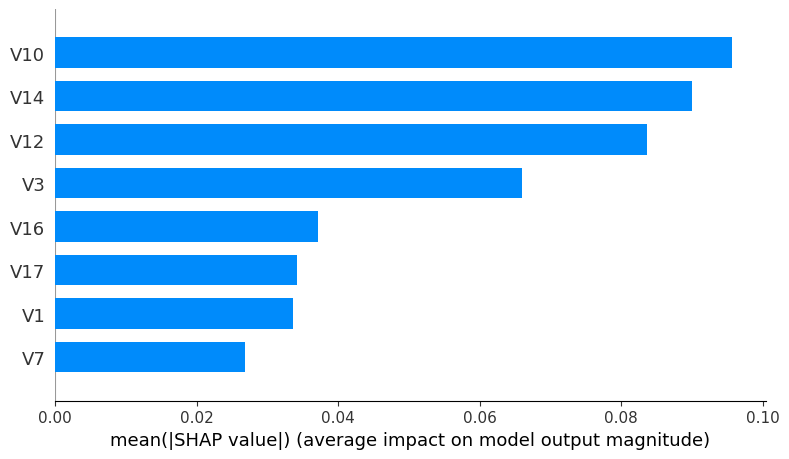

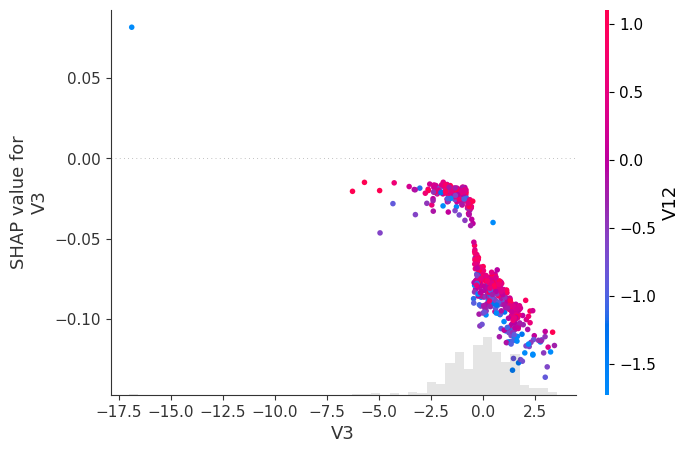

In [32]:
# Reload 50% for RF
df2 = pd.read_csv(data_path).sample(frac=0.5, random_state=42)
X2 = df2[strong_feats]
y2 = df2['Class']

X2_tr, X2_te, y2_tr, y2_te = train_test_split(X2, y2, test_size=0.2, stratify=y2, random_state=42)

# SMOTE to handle imbalance
sm = SMOTE(random_state=42)
X2_tr_sm, y2_tr_sm = sm.fit_resample(X2_tr, y2_tr)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X2_tr_sm, y2_tr_sm)

# Predict and evaluate on test set
y2_pr  = rf.predict(X2_te)
y2_prp = rf.predict_proba(X2_te)[:, 1]

print("\n📊 Random Forest Classification Report:\n", classification_report(y2_te, y2_pr))
print("🔢 Confusion Matrix:\n", confusion_matrix(y2_te, y2_pr))
print("🔥 ROC-AUC Score:", roc_auc_score(y2_te, y2_prp))

# SHAP Sampling
X_sub = X2_te.sample(n=500, random_state=42)
explainer = shap.Explainer(rf, X2_tr_sm)
shap_exp = explainer(X_sub)
shap_exp1 = shap_exp[..., 1]  # Focus on class 1

# SHAP Bar Plot
shap.summary_plot(shap_exp1.values, X_sub, plot_type="bar", max_display=len(strong_feats))

# SHAP Dependence Plot
sv3_1 = shap_exp1[:, "V3"]
sv12_1 = shap_exp1[:, "V12"]
shap.plots.scatter(sv3_1, color=sv12_1)

# SHAP Force Plot
shap.initjs()
shap.plots.force(shap_exp1[10])
